<div style="color:black;
           display:fill;
           border-radius:5px;
           background-color:#9FA7BD;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">

<h1 style="text-align: center;
           padding: 10px;
              color:black">

What is A brain tumor
</h1>
</div>

**1. Definition:**

A brain tumor is an abnormal growth of cells within the brain or the central nervous system. 

**2. Types:**
* Primary Brain Tumors: These originate in the brain or nearby structures. Examples include gliomas, meningiomas, astrocytomas, and medulloblastomas.
* Secondary (Metastatic) Brain Tumors: These occur when cancer cells from other parts of the body (like the lungs, breast, or skin) spread to the brain.

**3. Classification:**

Tumors can be classified as benign (non-cancerous) or malignant (cancerous). 
* Benign tumors grow slowly and generally do not spread.
* malignant tumors grow aggressively and can spread to other parts of the brain or body.

**4. Symptoms:**

Symptoms vary depending on the tumor's size, type, and location in the brain. Common symptoms include headaches, seizures, changes in vision or hearing, difficulty speaking, memory loss, personality changes, and motor skill impairments.

In [29]:
!pip install imutils
!pip install tensorflow-probability


You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [30]:
import os
import glob
import numpy as np 
import pandas as pd 
from os import listdir
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import imutils    

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Conv2D,Input,ZeroPadding2D,BatchNormalization,Flatten,Activation,Dense,MaxPooling2D, Cropping2D, Dropout, UpSampling2D
from sklearn.utils import shuffle #shuffling the data improves the model
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from scipy.stats import mode
import tensorflow as tf
import tensorflow_probability as tfp 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


<div style="color:black;
           display:fill;
           border-radius:5px;
           background-color:#9FA7BD;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">

<h1 style="text-align: center;
           padding: 10px;
              color:black">

Load DataSet
</h1>
</div>

In [31]:
Abnormal_IMAGES = glob.glob('../input/brain-mri-images-for-brain-tumor-detection/yes/*.jpg')
Normal_IMAGES = glob.glob('../input/brain-mri-images-for-brain-tumor-detection/no/*.jpg')

In [32]:

def load_image(path):
    image_list = np.zeros((len(path), 258, 540, 1))
    for i, fig in enumerate(path):
        img = image.load_img(fig, color_mode='grayscale', target_size=(258, 540))
        x = image.img_to_array(img).astype('float32')
        #normaliser les vals
        x = x / 255.0
        image_list[i] = x
    
    return image_list

In [33]:
X_normal = load_image(Normal_IMAGES)
X_abnormal = load_image(Abnormal_IMAGES)

print(X_normal.shape,X_abnormal.shape)

(85, 258, 540, 1) (86, 258, 540, 1)


In [34]:
def plot_sample(X_normal,chaine,num_samples = 5 ):
    # Créer des sous-graphes pour afficher des échantillons d'images normales
    fig, axes = plt.subplots(1, num_samples, figsize=(30, 5))

    # Afficher des exemples d'images normales
    for i in range(num_samples):
        axes[i].imshow(X_normal[i].squeeze(), cmap='gray')  # Utiliser squeeze() pour supprimer dimension 1 suplmentaire
        axes[i].axis('off')  # Masquer les axes
        axes[i].set_title(chaine)
    plt.show()

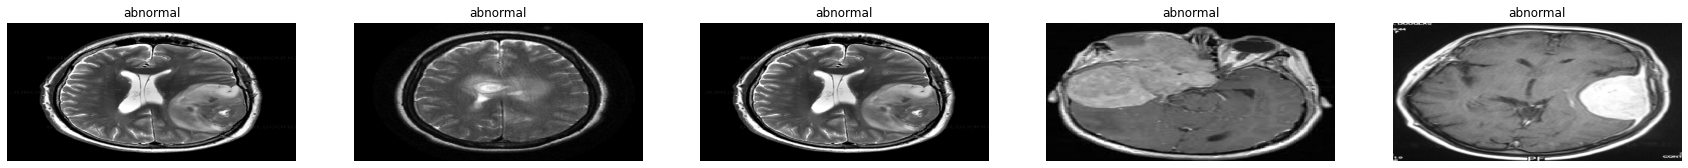

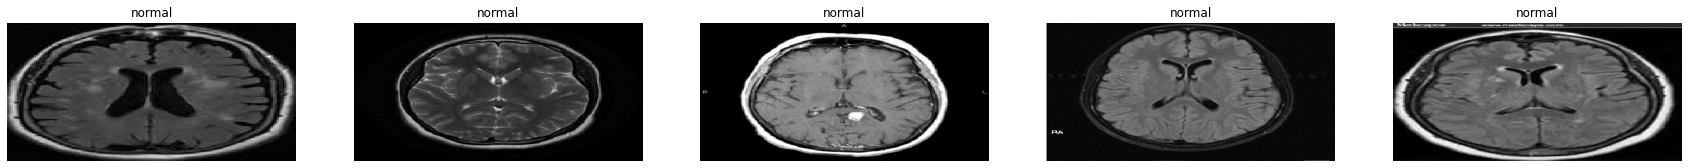

In [35]:
plot_sample(X_abnormal,"abnormal")
plot_sample(X_normal,"normal")

<div style="color:black;
           display:fill;
           border-radius:5px;
           background-color:#9FA7BD;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">

<h1 style="text-align: center;
           padding: 10px;
              color:black">

Generate Data
</h1>
</div>

In [36]:
datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True
)


def augment_images(data, labels, augmentations=10):
    augmented_data = []
    augmented_labels = []
    for i in range(augmentations):
        for x, y in zip(data, labels):
            augmented_image = datagen.random_transform(x)  # Appliquer une transformation aléatoire
            augmented_data.append(augmented_image)
            augmented_labels.append(y)
    return np.array(augmented_data), np.array(augmented_labels)

In [37]:
X_normal_augmented, y_normal_augmented = augment_images(X_normal, [1] * len(X_normal))
X_abnormal_augmented, y_abnormal_augmented = augment_images(X_abnormal, [0] * len(X_abnormal))

print(X_normal_augmented.shape,y_normal_augmented.shape,X_abnormal_augmented.shape)  

(850, 258, 540, 1) (850,) (860, 258, 540, 1)


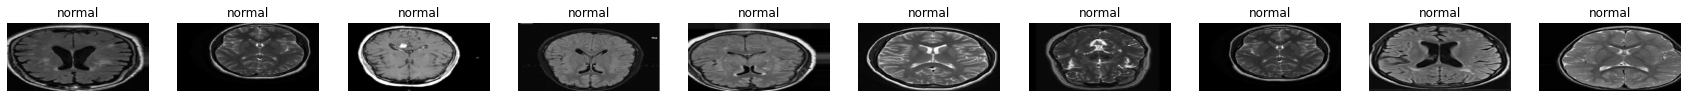

In [38]:
plot_sample(X_normal_augmented,"normal",10)

<div style="color:black;
           display:fill;
           border-radius:5px;
           background-color:#9FA7BD;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">

<h1 style="text-align: center;
           padding: 10px;
              color:black">

Split Data
</h1>
</div>

In [39]:
X_normal_train, X_normal_test = train_test_split(X_normal_augmented, test_size=0.2, random_state=42)
X_abnormal_train, X_abnormal_test= train_test_split(X_abnormal_augmented, test_size=0.2, random_state=42)

print(X_normal_train.shape, X_normal_test.shape, X_abnormal_train.shape, X_abnormal_test.shape)

(680, 258, 540, 1) (170, 258, 540, 1) (688, 258, 540, 1) (172, 258, 540, 1)


<div style="color:black;
           display:fill;
           border-radius:5px;
           background-color:#9FA7BD;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">

<h1 style="text-align: center;
           padding: 10px;
              color:black">

Create Autoencoder Class
</h1>
</div>

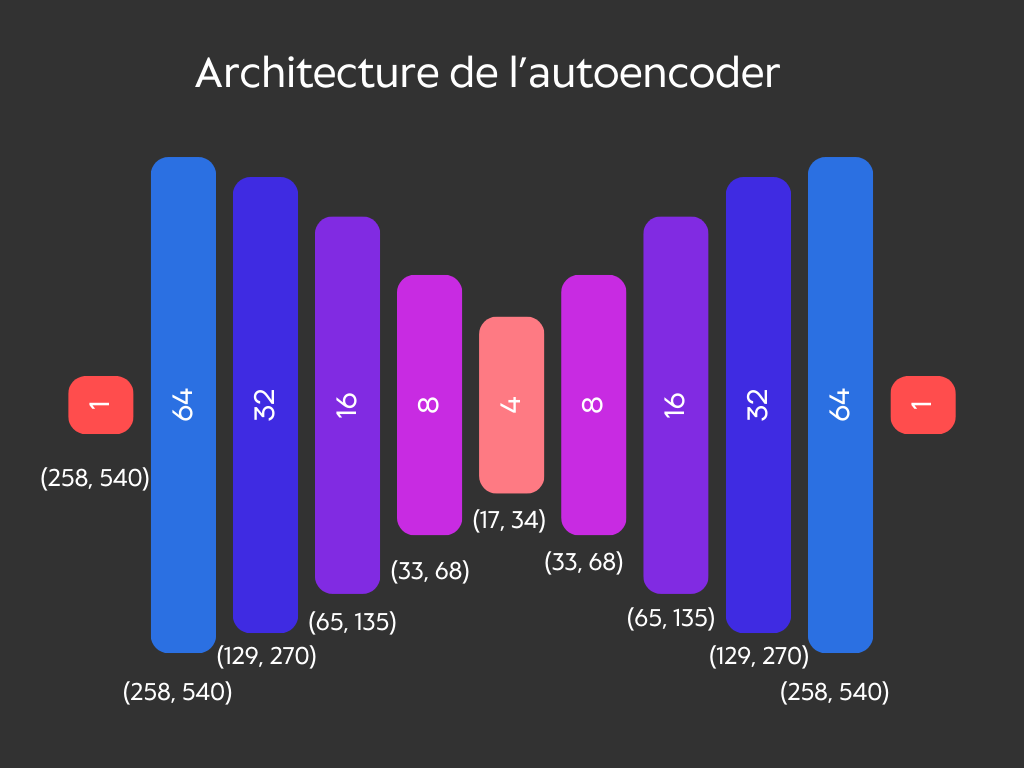

In [40]:
class Autoencoder():
    def __init__(self):
        
        self.img_shape = (258, 540, 1)
        optimizer = Adam(lr=0.0005)
        self.autoencoder_model = self.build_model()
        self.autoencoder_model.compile(loss='mse', optimizer=optimizer)
        self.autoencoder_model.summary()
    
    def build_model(self):
        input_layer = Input(shape=self.img_shape)
        
         # Encoder
        h = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer) 
        h = BatchNormalization()(h)
        
        h = Conv2D(32, (3, 3), activation='relu', padding='same')(h) 
        h = MaxPooling2D((2, 2), padding='same')(h)
        
        h = Conv2D(16, (3, 3), activation='relu', padding='same')(h)
        h = BatchNormalization()(h)
        h = MaxPooling2D((2, 2), padding='same')(h)  # Réduction de dimension
        
        h = Conv2D(8, (3, 3), activation='relu', padding='same')(h) 
        h = MaxPooling2D((2, 2), padding='same')(h) 
        
        
        h = Conv2D(4, (3, 3), activation='relu', padding='same')(h)
        h = BatchNormalization()(h)
        h = MaxPooling2D((2, 2), padding='same')(h)
        
        # Decoder
        
        h = Conv2D(8, (3, 3), activation='relu', padding='same')(h)
        h = UpSampling2D((2, 2))(h)
        h = Cropping2D(cropping=((1, 0), (0, 0)))(h)
        
        h = Conv2D(16, (3, 3), activation='relu', padding='same')(h) 
        h = BatchNormalization()(h)
        h = UpSampling2D((2, 2))(h)  # Upsampling pour revenir à la dimension précédente
        h = Cropping2D(cropping=((1, 0), (1, 0)))(h)
        
        h = Conv2D(32, (3, 3), activation='relu', padding='same')(h) 
        h = UpSampling2D((2, 2))(h)
        h = Cropping2D(cropping=((1, 0), (0, 0)))(h)

        
        h = Conv2D(64, (3, 3), activation='relu', padding='same')(h)
        h = BatchNormalization()(h)
        h = UpSampling2D((2, 2))(h)
        
        output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(h) 
        return Model(input_layer, output_layer)
    
    def train_model(self, x_train, y_train, x_val, y_val, epochs, batch_size=20):
        
        early_stopping = EarlyStopping(monitor='val_loss',
                                       min_delta=0,
                                       patience=5,  # Arrêt après 5 epochs sans amélioration
                                       verbose=1, 
                                       mode='auto')
        
        history = self.autoencoder_model.fit(x_train, y_train,
                                             batch_size=batch_size,
                                             epochs=epochs,
                                             validation_data=(x_val, y_val),
                                             callbacks=[early_stopping])
        
        plt.figure(figsize=(10, 5))
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.show()

    
    def eval_model(self, x_test):
        
        preds = self.autoencoder_model.predict(x_test)
        return preds

<div style="color:black;
           display:fill;
           border-radius:5px;
           background-color:#9FA7BD;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">

<h1 style="text-align: center;
           padding: 10px;
              color:black">

Train model
</h1>
</div>

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 258, 540, 1)]     0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 258, 540, 64)      640       
_________________________________________________________________
batch_normalization_10 (Batc (None, 258, 540, 64)      256       
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 258, 540, 32)      18464     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 129, 270, 32)      0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 129, 270, 16)      4624      
_________________________________________________________________
batch_normalization_11 (Batc (None, 129, 270, 16)     

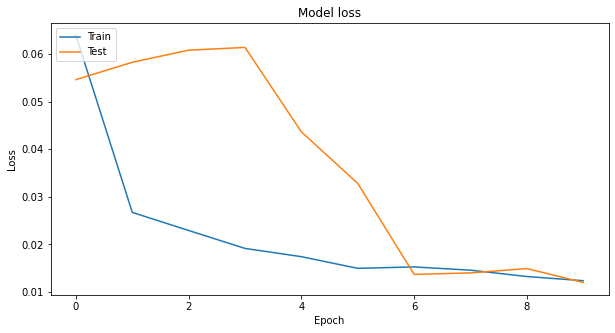

In [41]:
ae = Autoencoder()
ae.train_model(X_normal_train, X_normal_train, X_normal_test, X_normal_test, epochs=10, batch_size=10)

<div style="color:black;
           display:fill;
           border-radius:5px;
           background-color:#9FA7BD;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">

<h1 style="text-align: center;
           padding: 10px;
              color:black">

Reconstractions
</h1>
</div>

In [42]:
def plot_difference(pred, real):
    diff = np.abs(pred - real)  # la difference (posetive)

    plt.figure(figsize=(15, 5))

    # Image prédite
    plt.subplot(1, 3, 1)  
    plt.imshow(pred, cmap='gray')  
    plt.title("Image Prédite")
    plt.axis('off')

    # Image réelle
    plt.subplot(1, 3, 2) 
    plt.imshow(real, cmap='gray') 
    plt.title("Image Réelle")
    plt.axis('off')

    # Image de la différence
    plt.subplot(1, 3, 3)  
    plt.imshow(diff, cmap='hot')  # Utilisez une carte de chaleur pour visualiser les différences
    plt.title("Différence")
    plt.axis('off')

    plt.show()

In [43]:
preds_normal = ae.eval_model(X_normal_test)
preds_abnormal = ae.eval_model(X_abnormal_test)

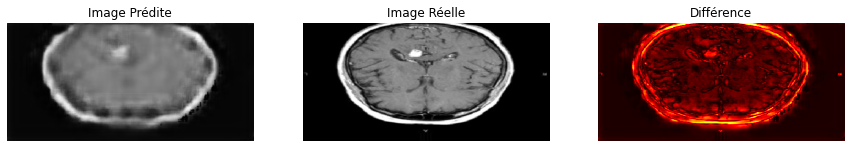

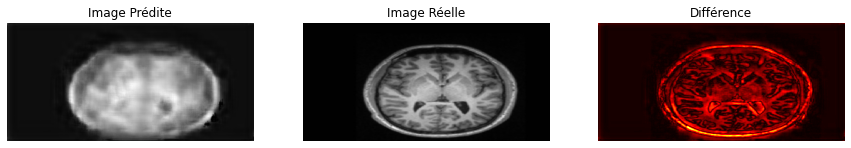

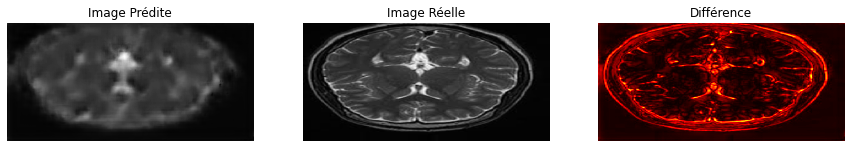

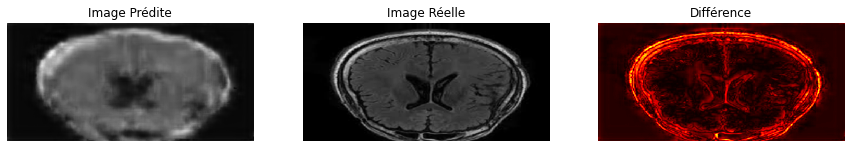

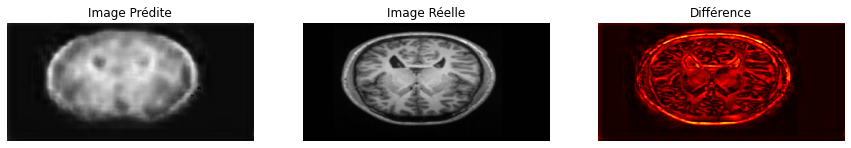

In [44]:
for i in range(5):
    pred_normal = preds_normal[i*2] * 255.0
    pred_normal = pred_normal.reshape(258, 540)
    real_normal = X_normal_test[i*2] * 255.0
    real_normal = real_normal.reshape(258, 540)

    plot_difference(pred_normal,real_normal)

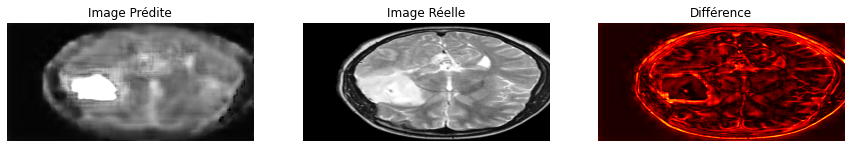

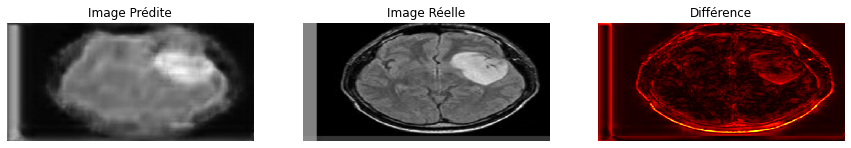

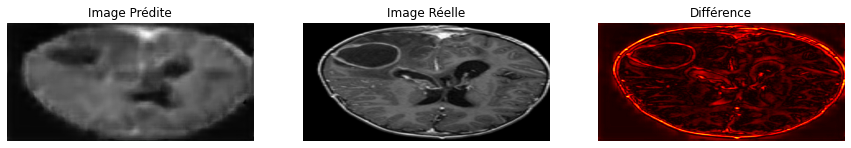

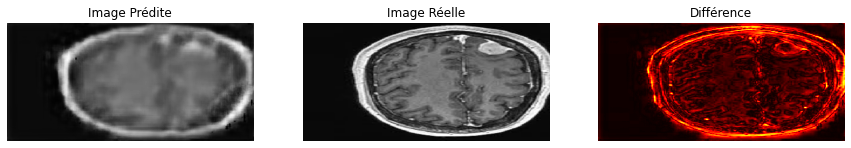

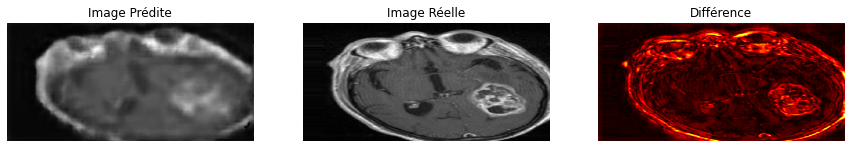

In [45]:
for i in range(5):
    pred_abnormal = preds_abnormal[i*2] * 255.0
    pred_abnormal = pred_abnormal.reshape(258, 540)
    real_abnormal = X_abnormal_test[i*2] * 255.0
    real_abnormal = real_abnormal.reshape(258, 540)

    plot_difference(pred_abnormal,real_abnormal)

<div style="color:black;
           display:fill;
           border-radius:5px;
           background-color:#9FA7BD;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">

<h1 style="text-align: center;
           padding: 10px;
              color:black">

Prepare Test data
</h1>
</div>

In [46]:
X_test = np.concatenate([X_normal_test, X_abnormal_test], axis=0)
X_test.shape

(342, 258, 540, 1)

In [47]:
normal_test_labels=[]
for i in range(X_normal_test.shape[0]):
    normal_test_labels.append(True)

abnormal_test_labels=[]
for i in range(X_abnormal_test.shape[0]):
    abnormal_test_labels.append(False)

labels_test= normal_test_labels +abnormal_test_labels
label_test = np.array(labels_test)  
label_test.shape

(342,)

<div style="color:black;
           display:fill;
           border-radius:5px;
           background-color:#9FA7BD;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">

<h1 style="text-align: center;
           padding: 10px;
              color:black">

Create Threshold
</h1>
</div>

In [48]:
def print_stats(predictions, labels):
    print("Accuracy = {}".format(accuracy_score(labels, predictions)))
    print("Precision = {}".format(precision_score(labels, predictions)))
    print("Recall = {}".format(recall_score(labels, predictions)))
    print("F1 score = {}".format(f1_score(labels, predictions)))


In [49]:
reconstructions = ae.eval_model(X_normal_train)
train_loss = tf.keras.losses.mae(reconstructions, X_normal_train)
mean = np.mean(train_loss)
std = np.std(train_loss)
mean

0.06518238140352174

In [50]:
def predict(model, data, threshold):
    # générer des reconstructions
    reconstructions = model.eval_model(data)

    # Calculer mean abslut error
    loss = tf.keras.losses.mae(reconstructions, data) 
    
    # Convertir la perte en un seul nombre pour chaque image, plutôt qu'une valeur par pixel
    image_losses = tfp.stats.percentile(loss, q=75, axis=[1, 2]) #puisque en generale la meme forme de irm
    #image_losses = tf.reduce_mean(loss, axis=[1, 2])
    
    return tf.math.less(image_losses, threshold).numpy()  #true si imageloss < threshold


In [51]:
for i in range(20):
    factor = i/10  # Exemple de facteur
    threshold_multiple_std = mean + factor * std # Seuil basé sur la moyenne et un multiple d'écart-type
    print("Threshold (Mean +"+str(i)+"/10 * Std Dev):", threshold_multiple_std)
    preds_std = predict(ae, X_test, threshold_multiple_std)
    print_stats(preds_std, label_test)

Threshold (Mean +0/10 * Std Dev): 0.06518238140352174
Accuracy = 0.5672514619883041
Precision = 0.6666666666666666
Recall = 0.25882352941176473
F1 score = 0.37288135593220334
Threshold (Mean +1/10 * Std Dev): 0.07357791312632514
Accuracy = 0.6286549707602339
Precision = 0.6837606837606838
Recall = 0.47058823529411764
F1 score = 0.5574912891986064
Threshold (Mean +2/10 * Std Dev): 0.08197344484912854
Accuracy = 0.6578947368421053
Precision = 0.6687898089171974
Recall = 0.6176470588235294
F1 score = 0.6422018348623852
Threshold (Mean +3/10 * Std Dev): 0.09036897657193192
Accuracy = 0.6549707602339181
Precision = 0.6413043478260869
Recall = 0.6941176470588235
F1 score = 0.6666666666666666
Threshold (Mean +4/10 * Std Dev): 0.09876450829473532
Accuracy = 0.6228070175438597
Precision = 0.5944700460829493
Recall = 0.7588235294117647
F1 score = 0.6666666666666666
Threshold (Mean +5/10 * Std Dev): 0.10716004001753872
Accuracy = 0.6169590643274854
Precision = 0.5783132530120482
Recall = 0.847058


In the context of brain tumor detection, it's crucial to have high recall to ensure that as many positive cases as possible are detected, even if it leads to some false positives. 

-> We choose de use Threshold (Mean +4/10 * Std Dev): 0.08079895495906178
* Accuracy = 0.6432748538011696
* Precision = 0.6111111111111112
* Recall = 0.7764705882352941
* F1 score = 0.683937823834197

In [52]:
threshold = mean + (4/10) * std
threshold

0.09876450829473532

In [53]:
preds_std = predict(ae, X_test, threshold)
print_stats(preds_std, label_test)

Accuracy = 0.6228070175438597
Precision = 0.5944700460829493
Recall = 0.7588235294117647
F1 score = 0.6666666666666666


<div style="color:black;
           display:fill;
           border-radius:5px;
           background-color:#9FA7BD;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">

<h1 style="text-align: center;
           padding: 10px;
              color:black">

Predictions
</h1>
</div>

array([ True])

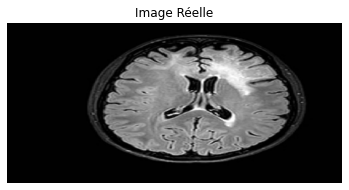

In [54]:
plt.imshow(np.squeeze(X_test[9]* 255.0), cmap='gray')  # Afficher l'image réelle normale
plt.title("Image Réelle")
plt.axis('off')

preds_mad = predict(ae, X_test[9:10], threshold)
preds_mad

array([False])

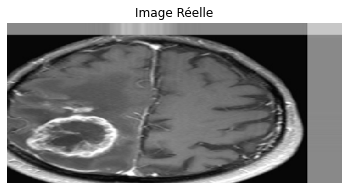

In [55]:
plt.imshow(np.squeeze(X_test[202]* 255.0), cmap='gray')  # Afficher l'image réelle
plt.title("Image Réelle")
plt.axis('off')

preds_mad = predict(ae, X_test[202:203], threshold)
preds_mad